In [152]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
import scipy.io
import scipy.linalg
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
from sklearn import metrics
from sklearn import svm
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

# Utils

In [153]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )


def sliding_window(T, T_org, seq_len, label_seq_len):  # was: (T, T_org, seq_len, label_seq_len)

    # seq_len is equal to window_size
    # T (np.ndarray) has dim: sample size, dim
    K = T.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
#     TT_org = T_org.reshape(-1, 1)

    # assemble the data into 3D
    x_set = T[:K, np.newaxis, :]
#     x_set = np.concatenate(TT[i : K+i, 0] for i in range(seq_len), axis=1)
    for i in range(1, seq_len):
        x_set = np.concatenate((x_set, T[i:K+i, np.newaxis, :]), axis=1)
    
    y_set = T_org[seq_len:K+seq_len, np.newaxis, :]
    for i in range(1, label_seq_len):
        y_set = np.concatenate((y_set, T_org[i+seq_len:K+i+seq_len, np.newaxis, :]), axis=1)
    
#     y_set = np.vstack(T_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: n_samp, seq_len
    return x_set, y_set


def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt('./outputs/BDA/'+var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt('./outputs/BDA/'+var_name(A)+'.csv', A, delimiter=',')

# 1. BDA Part
## 1.a. Define BDA methodology

In [154]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [155]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
#         ipdb.set_trace()
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X_mean = np.linalg.norm(X, axis=0)  # why it's axis=0? the average of features
        X_mean[X_mean==0] = 1
        X /= X_mean
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            print('\tStarting iter %i'%t)
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                for c in range(1, C + 1):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0  # ？
                    N = N + np.dot(e, e.T)

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
#             ipdb.set_trace()
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z_mean = np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Z_mean[Z_mean==0] = 1
            Z /= Z_mean
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            

        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

## 1.b. Load Data

In [210]:
file_set_2020 = [files for root, dirs, files in os.walk('./data/')][0][1::2]
# file_set_2020 = [files for root, dirs, files in os.walk('./data/')][0][2::2]

from_date = 55
to_date = 67
src_data = np.zeros([to_date - from_date, 96, 13])  # num_days, time_seg_per_day, num_dets
tar_data = np.zeros([to_date - from_date, 96, 10])  # num_days, time_seg_per_day, num_dets
# choosing date, 
weekdays = np.array([0,1,2,3,6,7,8,9,10])
weekends = np.array([4,5,11])
day_type = weekdays
src_data = src_data[day_type, :, :]
tar_data = tar_data[day_type, :, :]

for i in range(23):  # 23 M1 csv
    # from_date 和 to_date
    if i<13:
        src_data[:, :, i] += np.array(pd.read_csv('./data/'+file_set_2020[i]).iloc[from_date:to_date, 1:-1])[day_type, :]
    else:
        tar_data[:, :, i-13] += np.array(pd.read_csv('./data/'+file_set_2020[i]).iloc[from_date:to_date, 1:-1])[day_type, :]

# Xs = src_data.reshape(-1, 23)[:, :13][:, np.array([0,1,2,3,5,6,8,9,10,11])]  # choosing detectors
# Xt = tar_data.reshape(-1, 13)[:, np.array([0,1,2,3,5,6,8,9,10,11])]

Xs = src_data.reshape(-1, 13)[:, np.array([0,1,2,3,5,6,8,9,10,11])]
Xt = tar_data.reshape(-1, 10)

Xs = (Xs - Xs.min(0))/(Xs.max(0)-Xs.min(0))
Xt = (Xt - Xt.min(0))/(Xt.max(0)-Xt.min(0))

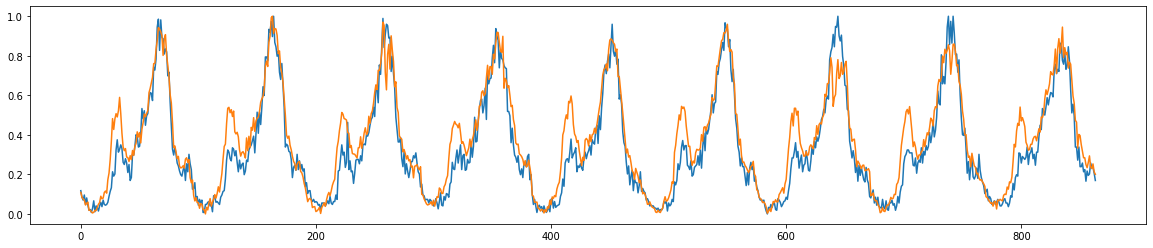

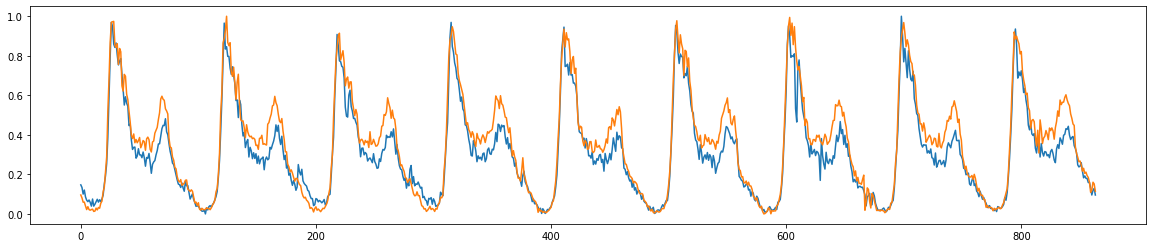

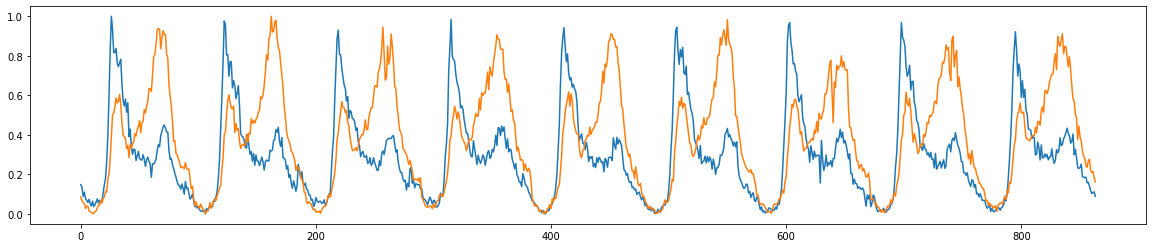

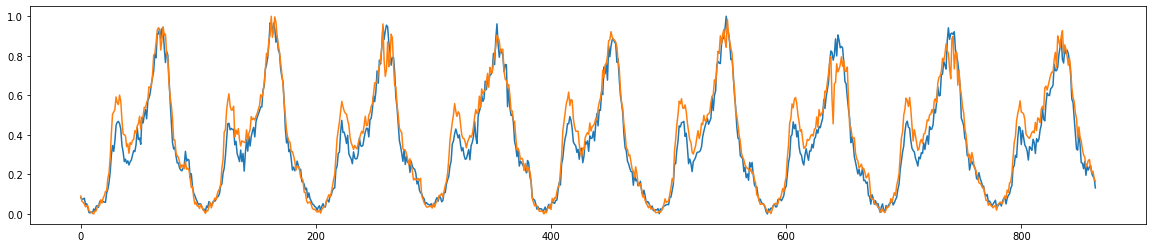

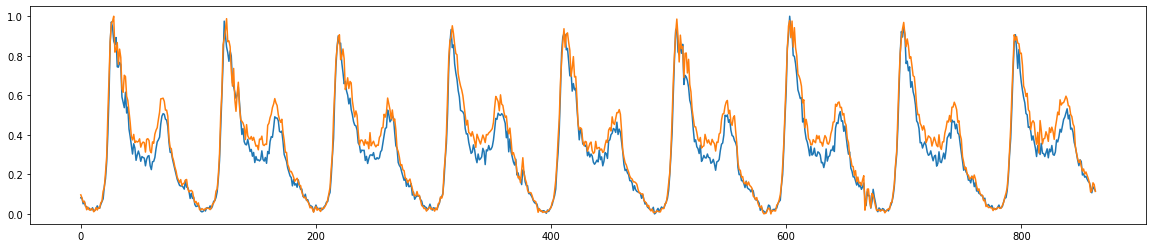

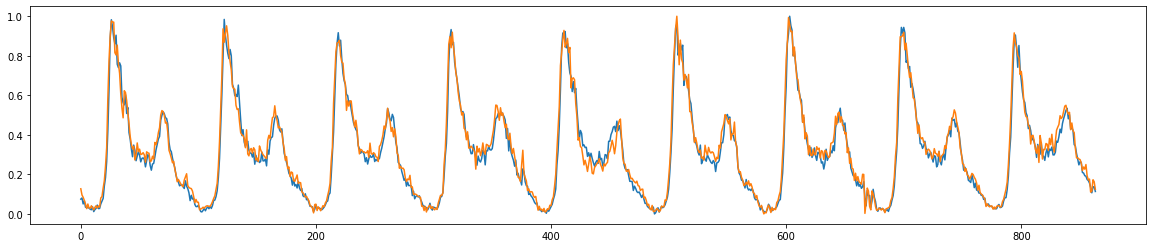

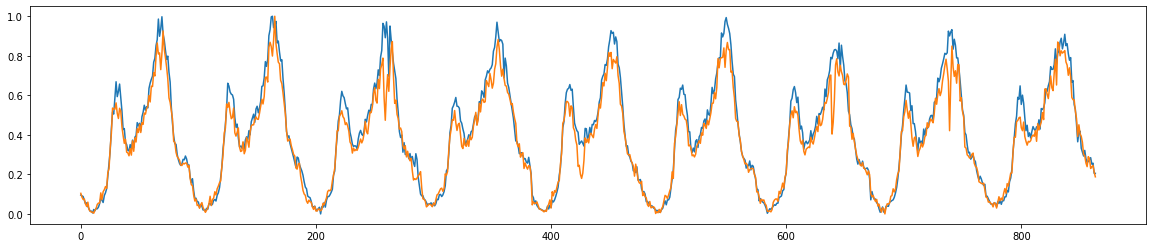

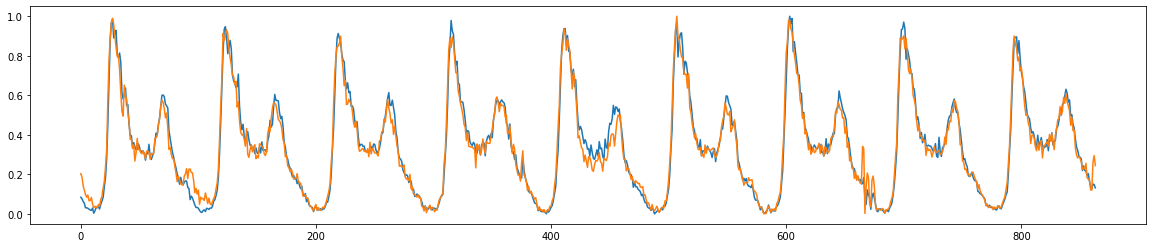

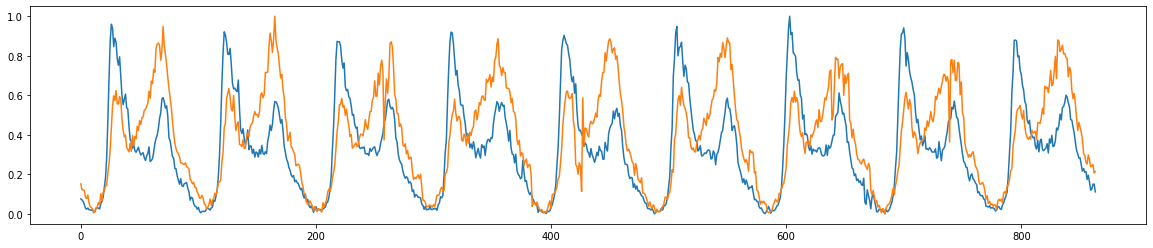

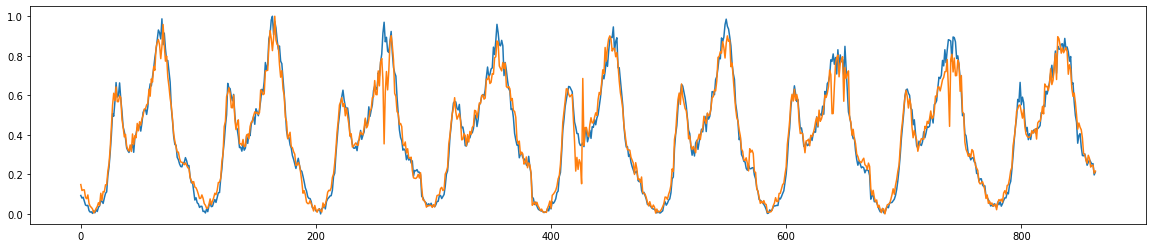

In [211]:
for i in range(10):
    plt.figure(figsize=[20,4])
    plt.plot(Xs[:, i])
    plt.plot(Xt[:, i])

weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()
weekends = np.array([np.arange(7+7*i,9+7*i,1) for i in range(3)]).flatten()[:-1]

src_domain = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2168B_20210101_20210131.csv'))[np.array([5,6,7,8]), :]
data_target = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2188B_20210101_20210131.csv'))[20:25, :]

date_choosen = 10
num_test_day = 4
#tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tar_domain = data_target.copy()
tgt_validation = tar_domain[1:num_test_day+1, :]

Xs = normalize(src_domain.flatten())
Xt = normalize(tar_domain.flatten())

## 1.d. Hyperparameters

In [212]:
label_seq_len = 3
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [213]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,10,10,3,12,4,12,1,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [214]:
t_s = time.time()

_, Ys = sliding_window(Xs, Xs, 0, 0)  
_, Yt = sliding_window(Xt, Xt, 0, 0)
assert(Ys.shape[0]==Xs.shape[0])
bda = BDA(kernel_type='linear', dim=inp_dim-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
Xs_new, Xt_new, A = bda.fit(Xs, Ys, Xt, Yt)  # input shape: ns, n_feature | ns, n_label_feature

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xs_new)
np2csv(Xt_new)

print('Time spent:%.5f'%(time.time()-t_s))

	Starting iter 0
(864, 6)
(864, 6)
Time spent:16.54774


In [215]:
# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_train, Ys_train = sliding_window(Xs_new, Xs, seq_len, 1)  
Xt_train, Yt_train = sliding_window(Xt_new, Xt, seq_len, 1)
Xt_valid = Xt_train.copy()[int(96*3):, :]
Xt_train = Xt_train.copy()[:int(96*3), :]
Yt_valid = Yt_train.copy()[int(96*3):, :]
Yt_train = Yt_train.copy()[:int(96*3), :]

In [216]:
print(Xs_train.shape)
print(Ys_train.shape)
print('\n')
print(Xt_train.shape)
print(Yt_train.shape)
print('\n')
print(Xt_valid.shape)
print(Yt_valid.shape)

(852, 12, 6)
(852, 1, 10)


(288, 12, 6)
(288, 1, 10)


(564, 12, 6)
(564, 1, 10)


# 2. Learning Part

## 2.a. Build network

In [217]:
class traff_net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(traff_net, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.3, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim*12, hid_dim*2),  # 12 means seq_len
            nn.ReLU(),
            nn.Linear(hid_dim*2, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (batchsize, seq_len, input_dim)
        # output: (batchsize, seq_len, hid_dim)
#         ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = nn.Flatten()(y)
        
        y = self.fc(y)  # fully connected layer
        
        return y[:, :]

## 2.b. Assemble Dataloader

In [218]:
batch_size = 1960

train_x = np.vstack([Xs_train, Xt_train])
train_y = np.vstack([Ys_train, Yt_train])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_valid = torch.tensor(Xt_valid, dtype=torch.float32).to(device)
Yt_valid = torch.tensor(Yt_valid, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
train_iter = iter(train_loader)

## 2.c. Learn

In [219]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = traff_net(inp_dim-reduced_dim, label_dim, hid_dim=12, layers=6).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)
train_loss_set = []
val_loss_set = []

det = 5  # which detector to visualize

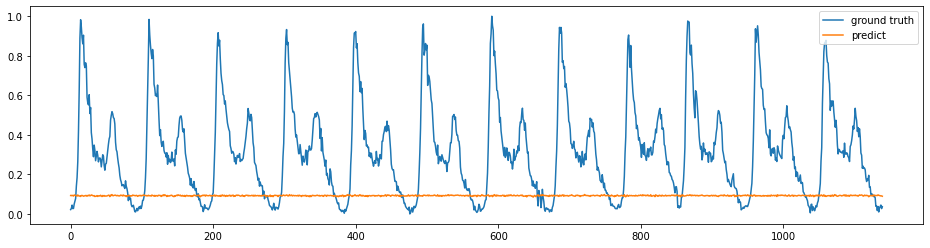

Epoch No. 0 success, loss: 0.17549, val loss: 0.15918


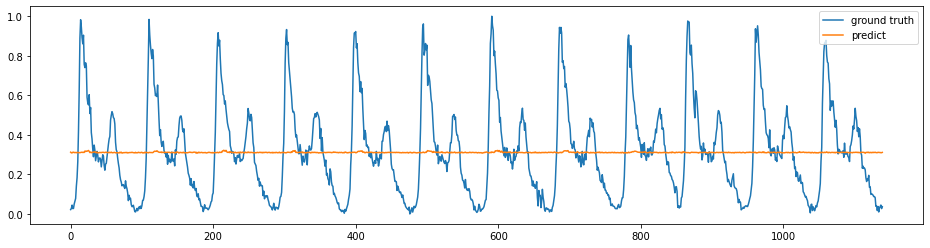

Epoch No. 200 success, loss: 0.06057, val loss: 0.06088


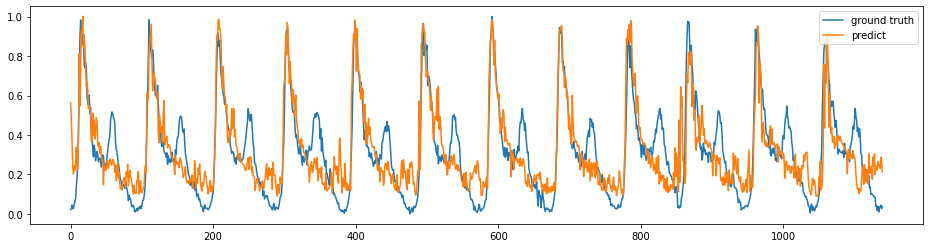

Epoch No. 400 success, loss: 0.03174, val loss: 0.04217


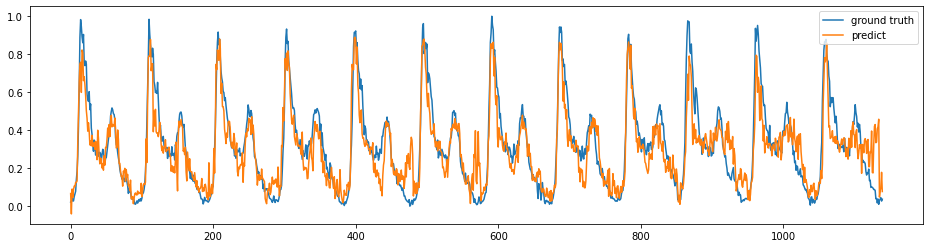

Epoch No. 600 success, loss: 0.01862, val loss: 0.03076


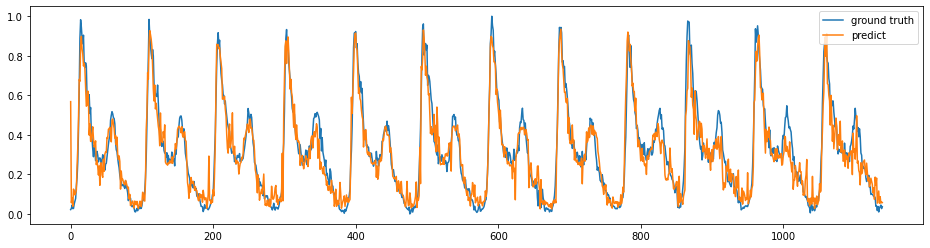

Epoch No. 800 success, loss: 0.00881, val loss: 0.02171


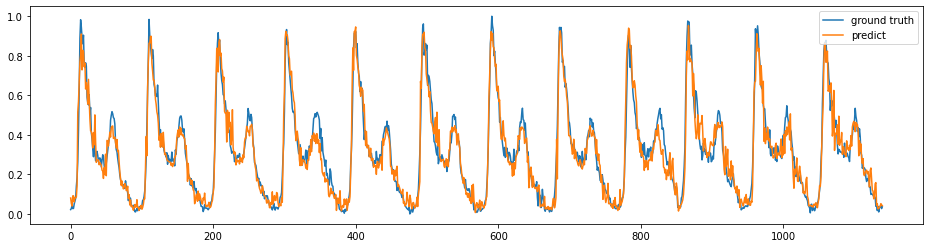

Epoch No. 1000 success, loss: 0.00536, val loss: 0.02069


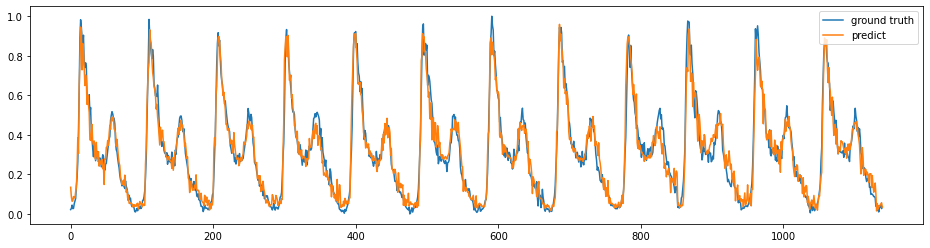

Epoch No. 1200 success, loss: 0.00420, val loss: 0.01955


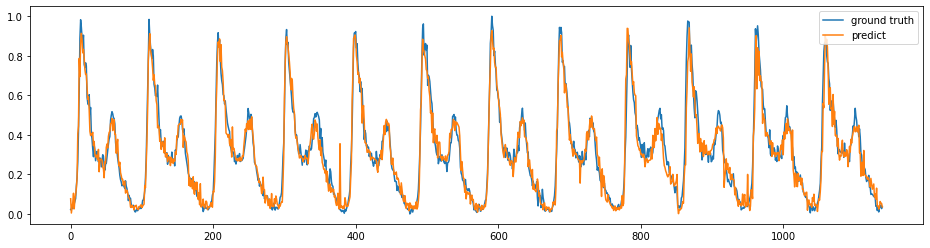

Epoch No. 1400 success, loss: 0.00402, val loss: 0.01948


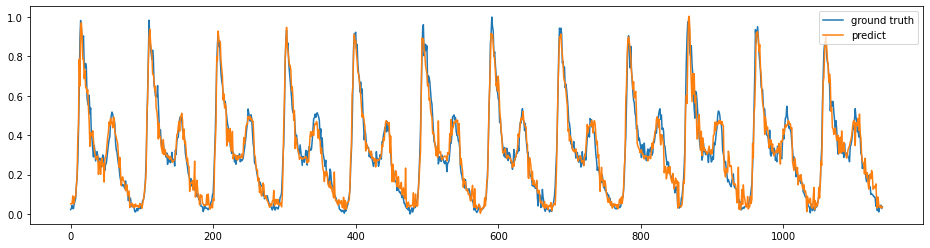

Epoch No. 1600 success, loss: 0.00397, val loss: 0.01862


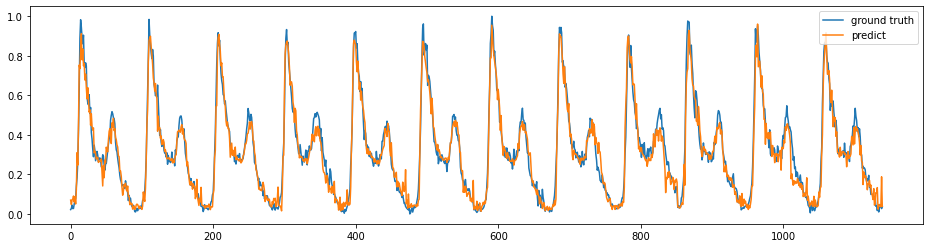

Epoch No. 1800 success, loss: 0.00380, val loss: 0.02319


In [220]:
# train
net.train()

epochs = 2000

for e in range(epochs):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
#         ipdb.set_trace()
        out = net(data)
#         print(out.shape)
#         print(label.shape)
        loss = criterion(out, label[:, 0, :])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_valid)
#         print(val_out.shape)
#         print(Yt_valid.shape)
        val_loss = criterion(val_out, Yt_valid[:, 0, :])
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
        
    if e%200==0:
        fig = plt.figure(figsize=[16,4])
        ax1 = fig.add_subplot(111)
        ax1.plot(label[:, :, det].cpu().detach().numpy(), label='ground truth')
        ax1.plot(out[:, det].cpu().detach().numpy(), label='predict')
        ax1.legend()
        plt.show()
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'%(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy()))

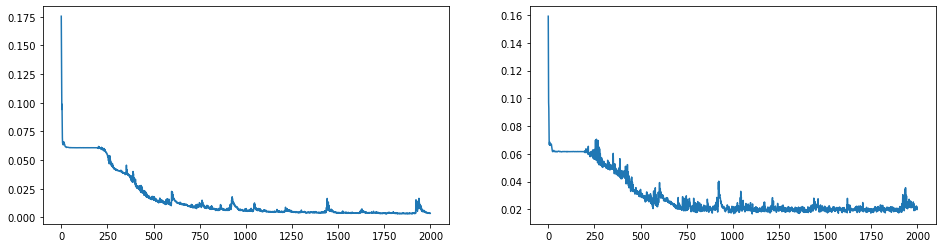

In [221]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

In [222]:
def mape_loss_func(preds, labels, m):
    mask = labels > m
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels, m):
    mask= labels > m
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels, m):
    mask= labels > m
    return np.mean(np.fabs((labels[mask]-preds[mask])))

def nrmse_loss_func(preds, labels, m):
    mask= labels > m
    return np.sqrt(np.sum((preds[mask] - labels[mask])**2)/preds[mask].flatten().shape[0])/(preds[mask].max() - preds[mask].min())

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

In [ ]:
val_out = val_out.cpu().detach().numpy()
Yt_valid = Yt_valid.cpu().detach().numpy()

In [231]:
net.eval()
m = 0.1

print('NRMSE: %.5f'%nrmse_loss_func(val_out, Yt_valid[:, 0, :], m))
print('MAPE: %.5f'%mape_loss_func(val_out, Yt_valid[:, 0, :], m))
print('SMAPE: %.5f'%smape_loss_func(val_out, Yt_valid[:, 0, :], m))
print('MAE: %.5f'%mae_loss_func(val_out, Yt_valid[:, 0, :], m))

NRMSE: 0.13825
MAPE: 0.28509
SMAPE: 0.26115
MAE: 0.09926


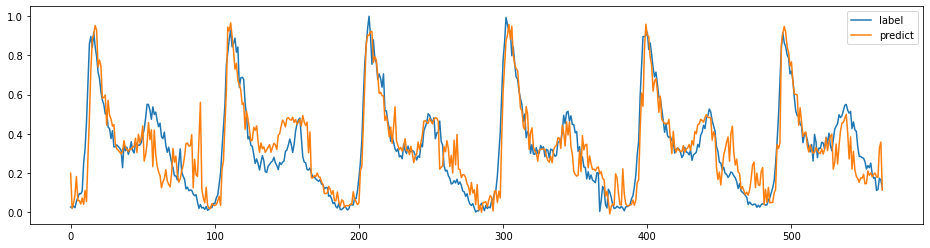

In [224]:
plt.figure(figsize=[16,4])
plt.plot(Yt_valid[:, 0, det], label='label')
plt.plot(val_out[:, det], label='predict')
plt.legend()